# Lecture 3: Convolutional Neural Networks and Segmentation & Detection
Welcome to this hands-on tutorial on **Convolutional Neural Networks (CNNs)**, a transformative innovation in deep learning that has revolutionized computer vision tasks. In this notebook, we’ll explore the fundamental building blocks of CNNs and their applications in **image segmentation**, a task that involves classifying each pixel in an image into meaningful categories.

CNNs are particularly well-suited for computer vision tasks due to their ability to learn spatial hierarchies of features, such as edges, textures, and object parts, by applying convolutional filters. These filters act as feature extractors, identifying patterns in local regions of an image.

By the end of this notebook, you’ll understand how to:

1) Visualize convolutional filters and grasp their role in feature extraction.
2) Build and train a basic CNN model using PyTorch.
3) Implement your first segmentation model and evaluate its performance on a dataset.

Our journey begins with understanding the motivation behind CNNs and why they outperform traditional Multi-Layer Perceptrons (MLPs) for image analysis tasks. Next, we'll dive into the implementation of a segmentation pipeline, showcasing the practical power of CNNs.

Let’s get started!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Step 1: Understand the limitations of general MLPs
In this section, we'll revisit the constraints inherent in general MLPs. We'll start by defining an MLP class and then explore the consequences when attempting to increase the number of hidden layers.

In [7]:
# Function to create a Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, num_hidden_layers, hidden_layer_size):
        super(MLP, self).__init__()
        layers_list = []
        layers_list.append(nn.Flatten())      

        for i in range(num_hidden_layers):
            if i == 0: # create first layers
                layers_list.append(nn.Linear(32*32*1, hidden_layer_size)) # 32*32*3 = cifar image x,y size and RGB channels
            else:
                layers_list.append(nn.Linear(hidden_layer_size, hidden_layer_size))
                
            layers_list.append(nn.ReLU())

        # Output layer
        layers_list.append(nn.Linear(hidden_layer_size, 10))  # Assuming 10 classes for CIFAR-10

        self.mlp = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.mlp(x)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
num_hidden_layers_list = [1, 2, 5, 10]
hidden_layer_size = 64


# Loop through different numbers of hidden layers
for num_hidden_layers in num_hidden_layers_list:
    # Create and train the model
    model = MLP(num_hidden_layers, hidden_layer_size)
    
    # Count the number of parameters
    num_params = count_parameters(model)
    print(f"Number of parameters for {num_hidden_layers}-layer MLP: {num_params}")


Number of parameters for 1-layer MLP: 66250
Number of parameters for 2-layer MLP: 70410
Number of parameters for 5-layer MLP: 82890
Number of parameters for 10-layer MLP: 103690


You can clearly see that the number of **trainable parameters** increases heavily with an increase in hidden layers. Now let's train these different models!

In [9]:
def train_model(model, train_loader, num_epochs=5, lr=0.01, device="cpu"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def test_model(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on the test set: {:.2f}%'.format(accuracy))
        

We will make use of the same dataset used in the first notebook, CIFAR-10. However to make the next part about convolutions a bit more intuitive we will transform the images to 1-channel grayscale images.

In [11]:
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),# Converts to grayscale
      
])

cifar_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=10,
                                          shuffle=True, num_workers=2)

cifar_test = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=10,
                                          shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
import time

learning_rate = 0.01
nb_epochs = 10

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for num_hidden_layers in num_hidden_layers_list:
    
    # Create and train the model
    model = MLP(num_hidden_layers, hidden_layer_size).to(device)
    # Count the number of parameters
    num_params = count_parameters(model)
    print(f"Number of parameters for {num_hidden_layers}-layer MLP: {num_params}")
    
    # Move data to GPU
    trainloader = [(x.to(device), y.to(device)) for x, y in trainloader]
    testloader = [(x.to(device), y.to(device)) for x, y in testloader]

    # Start model training 
    start_time = time.time()
    train_model(model, trainloader, nb_epochs, learning_rate, device)
    end_time = time.time()
       
    execution_time = end_time - start_time
    print(f"Time taken for {num_hidden_layers}-layer MLP: {execution_time:.2f} seconds")
    
    # Test model
    test_model(model, testloader, device)

Using device: cuda
Number of parameters for 1-layer MLP: 66250
Epoch 1/10, Loss: 2.1704
Epoch 2/10, Loss: 2.1271
Epoch 3/10, Loss: 2.1020
Epoch 4/10, Loss: 2.0802
Epoch 5/10, Loss: 2.0660
Epoch 6/10, Loss: 2.0449
Epoch 7/10, Loss: 2.0325
Epoch 8/10, Loss: 2.0160
Epoch 9/10, Loss: 2.0090
Epoch 10/10, Loss: 2.0003
Time taken for 1-layer MLP: 61.70 seconds
Accuracy on the test set: 26.17%
Number of parameters for 2-layer MLP: 70410
Epoch 1/10, Loss: 2.0898
Epoch 2/10, Loss: 2.0050
Epoch 3/10, Loss: 1.9812
Epoch 4/10, Loss: 1.9637
Epoch 5/10, Loss: 1.9490
Epoch 6/10, Loss: 1.9373
Epoch 7/10, Loss: 1.9291
Epoch 8/10, Loss: 1.9248
Epoch 9/10, Loss: 1.9182
Epoch 10/10, Loss: 1.9091
Time taken for 2-layer MLP: 76.61 seconds
Accuracy on the test set: 30.84%
Number of parameters for 5-layer MLP: 82890
Epoch 1/10, Loss: 2.1493
Epoch 2/10, Loss: 2.0257
Epoch 3/10, Loss: 1.9753
Epoch 4/10, Loss: 1.9404
Epoch 5/10, Loss: 1.9157
Epoch 6/10, Loss: 1.8946
Epoch 7/10, Loss: 1.8855
Epoch 8/10, Loss: 1.87

In [13]:
# # https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later
# import dill
# dill.dump_session('notebook_env.db')

In [14]:
# import dill
# dill.load_session('NNCV/Weekly notebooks/notebook_env.db')



## Questions
**Q1**. What happens to the training time when you increase the number of hidden layers?

**Q2**. How does the loss change with an increase in hidden layers?

**Q3**. Why do you think the accuracy of the model decreases for the 10 layer MLP?

## Step 2: Implement Convolutional Filters
First, let's observe how an image transforms after applying a convolutional filter. Experiment with defining at least three general convolutional filters and observe the resulting images after applying these filters.

Files already downloaded and verified


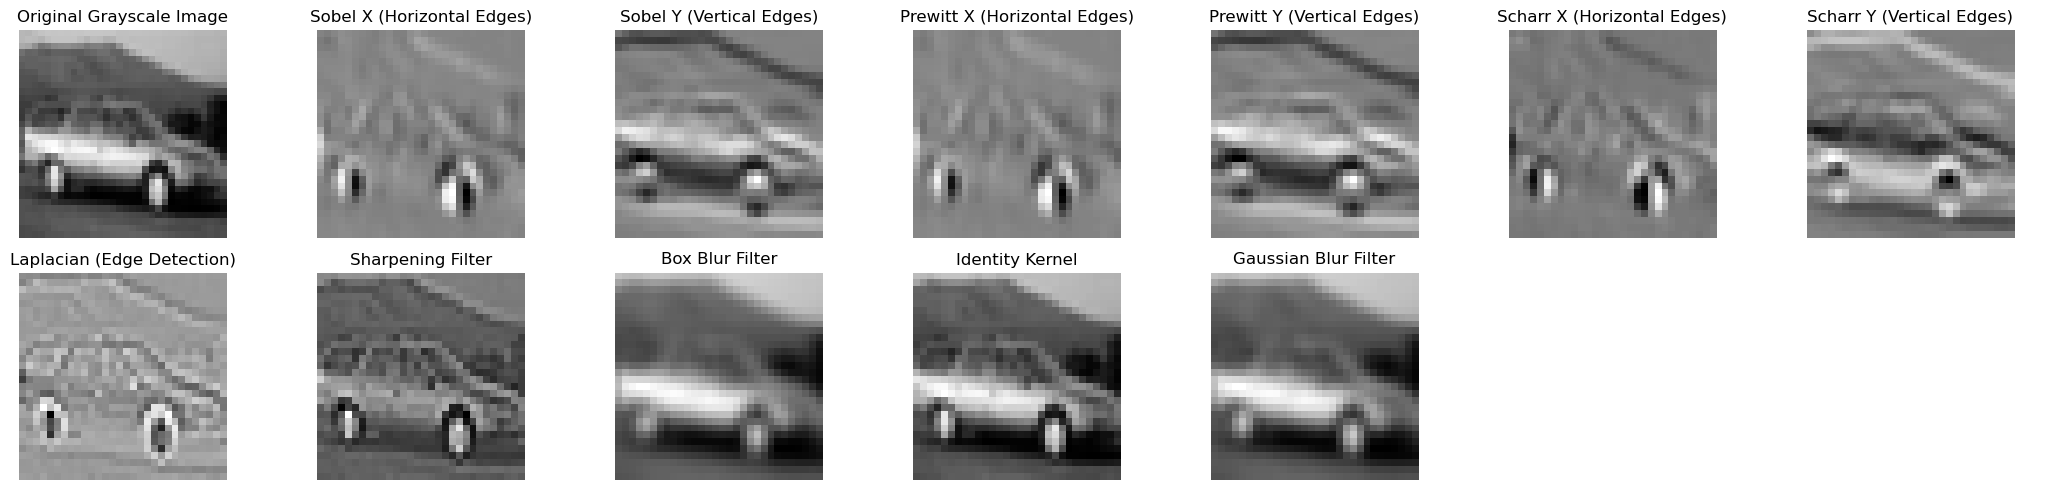

In [ ]:
# Set up a transform to convert images to tensors and grayscale
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1), # Converts to grayscale
      
])

# Load a single grayscale image
cifar_train = datasets.CIFAR10(root='./data', train=True,
                                download=True, transform=transform)

image, label = cifar_train[4]
gray_image = image.squeeze().numpy()

# Function to apply 2D convolution with multiple filters
def apply_convolutions(image, kernels):
    image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    results = [
        F.conv2d(image_tensor, kernel.unsqueeze(0).unsqueeze(0).float().to(device), padding=0).squeeze().cpu().numpy()
        for kernel in kernels
    ]
    return results

# Function to display images
def display_images(images, titles):
    plt.figure(figsize=(len(images) * 3, 3))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

# Define multiple convolutional filters (kernels), these should be a 2x2 or 3x3 pytorch tensor
kernels = [
    torch.tensor([
        [-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]
    ], dtype=torch.float32),   # Sobel filter for horizontal edges
    
    torch.tensor([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ], dtype=torch.float32),    # Sobel filter for veretical edges

    torch.tensor([
        [-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]
    ], dtype=torch.float32),   # Prewitt filter for horizontal edges

    torch.tensor([
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]
    ], dtype=torch.float32),    # Prewitt  filter for veretical edges

    torch.tensor([
        [3,  0,  -3],
        [10,  0,  -10],
        [3,  0,  -3]
    ], dtype=torch.float32),   # Scharr filter for horizontal edges

    torch.tensor([
        [3, 10, 3],
        [ 0,  0,  0],
        [ -3,  -10,  -3]
    ], dtype=torch.float32),    # Scharr filter for veretical edges

    torch.tensor([
        [ 0,  1,  0],
        [ 1, -4,  1],
        [ 0,  1,  0]
    ], dtype=torch.float32),    # Laplacian filtere for edges

    torch.tensor([
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0]
    ], dtype=torch.float32), # Sharpening filter

    torch.tensor([  
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9]
    ], dtype=torch.float32),    # Box Blur filter

    torch.tensor([
        [ 0,  0,  0],
        [ 0, 1,  0],
        [ 0,  0,  0]
    ], dtype=torch.float32),    # Identity Kernel

    1/16 * torch.tensor([
        [ 1,  2,  1],
        [ 2, 4,  2],
        [ 1,  2,  1]
    ], dtype=torch.float32),    # Gaussian Blur Kernel
]

# Move kernels to GPU
kernels = [kernel.to(device) for kernel in kernels]

# Apply 2D convolution with multiple filters
results = apply_convolutions(gray_image, kernels)

# Define filter names
filter_names = [
    'Original Grayscale Image', 
    'Sobel X (Horizontal Edges)', 'Sobel Y (Vertical Edges)', 
    'Prewitt X (Horizontal Edges)', 'Prewitt Y (Vertical Edges)', 
    'Scharr X (Horizontal Edges)', 'Scharr Y (Vertical Edges)', 
    'Laplacian (Edge Detection)', 'Sharpening Filter', 
    'Box Blur Filter', 'Identity Kernel', 'Gaussian Blur Filter'
]

import math

# Function to display images in rows of 7
def display_images_in_rows(images, titles, images_per_row=7):
    num_images = len(images)
    num_rows = math.ceil(num_images / images_per_row)  # Calculate required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3.5))  # Larger images
    axes = axes.flatten()  # Flatten axes for easy iteration

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(title, fontsize=12)  # Bigger titles
        axes[i].axis('off')

    # Hide any unused subplots (if images don't perfectly fill the grid)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Display original image and results
images = [gray_image] + results
display_images_in_rows(images, filter_names)

Now, attempt to implement a basic CNN architecture. Refer to the lecture slides for guidance on its structure and components.

In [31]:
# Define the SimpleCNN model, for visualization purpose please refer to the first convolutional layer as conv1.
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # TODO: (1) make a CNN classification model consiting out of at least 3 convolutional building blocks. (2) the first convolutional
        # layers should be refered to as self.conv1 for visualization purpose. (3) the output layer that returns the output 
        # for the 10 classes (NOTE: we flatten the images; see forward function)
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fully connected layer (output layer)
        self.fc1 = nn.Linear(128 * 4 * 4, num_classes)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional block
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional block
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layer
        x = self.fc1(x)
        return x

In [32]:
simple_cnn = SimpleCNN().to(device)
nb_epochs = 10
learning_rate = 0.01

# Create and train the model
num_params = count_parameters(simple_cnn)
print(f"Number of parameters for CNN: {num_params}")

# Start model training 
train_model(simple_cnn, trainloader, nb_epochs, learning_rate, device)
test_model(simple_cnn, testloader,device)

Number of parameters for CNN: 113162
Epoch 1/10, Loss: 1.5993
Epoch 2/10, Loss: 1.2228
Epoch 3/10, Loss: 1.1189
Epoch 4/10, Loss: 1.0747
Epoch 5/10, Loss: 1.0499
Epoch 6/10, Loss: 1.0411
Epoch 7/10, Loss: 1.0363
Epoch 8/10, Loss: 1.0251
Epoch 9/10, Loss: 1.0226
Epoch 10/10, Loss: 1.0217
Accuracy on the test set: 60.19%


In [33]:
def visualize_filters(model, layer_name, num_filters=16):
    """
    Visualize filters from a specific convolutional layer in the model.

    Parameters:
        - model: The CNN model
        - layer_name: The name of the convolutional layer (e.g., 'conv1', 'conv2', 'conv3')
        - num_filters: Number of filters to visualize

    Returns:
        None (displays the visualizations)
    """
    # Get the specified convolutional layer
    layer = getattr(model, layer_name)

    # Get the weights from the layer
    filters = layer.weight.data.cpu().numpy()
    
    # Get min and max value of all filters to scale plots
    min_value = filters.min()
    max_value = filters.max()

    # Plot the filters
    plt.figure(figsize=(12, 6))
    for i in range(num_filters):
        plt.subplot(2, num_filters // 2, i + 1)
        plt.imshow(filters[i][0], cmap='gray', vmin=min_value, vmax=max_value)
        plt.axis('off')
        plt.title(f'Filter {i + 1}')

    plt.suptitle(f'Filters from {layer_name}', fontsize=16)
    plt.show()

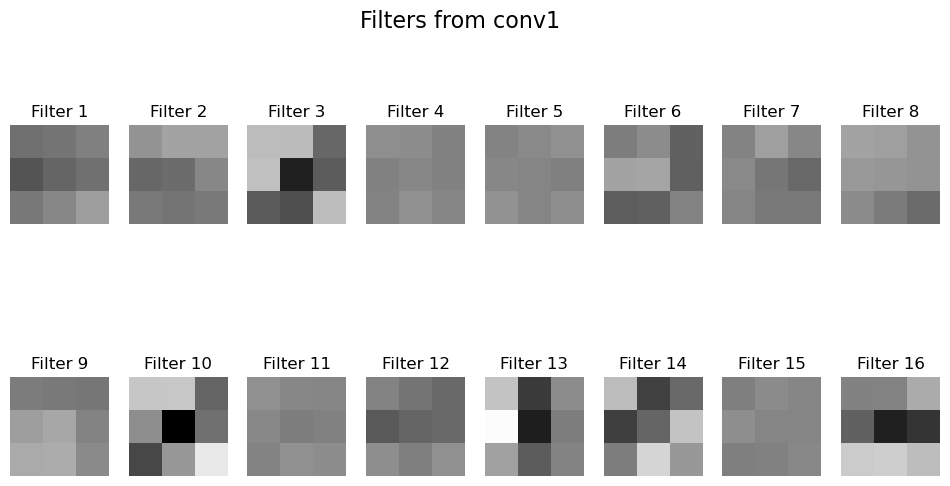

In [34]:
simple_cnn.eval()

# Visualize filters from the first convolutional layer
visualize_filters(simple_cnn, 'conv1', num_filters=16)

Files already downloaded and verified


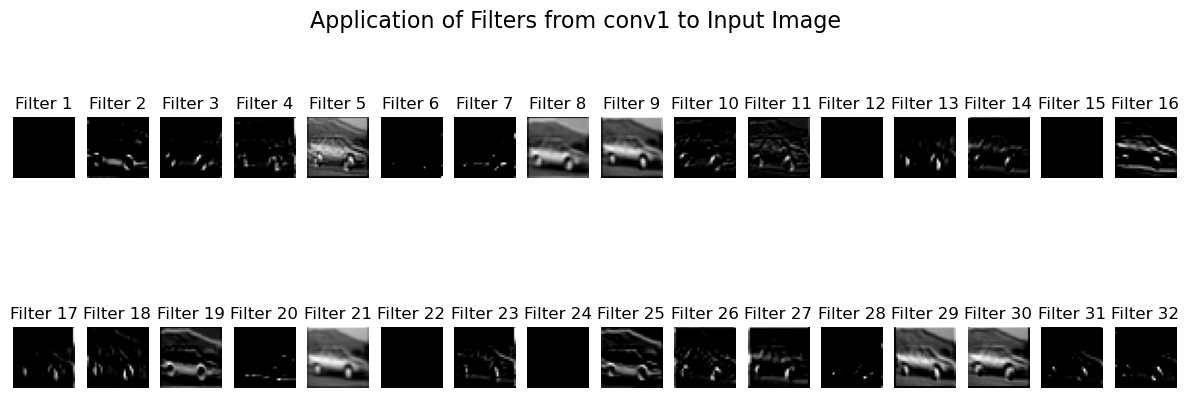

In [36]:
def apply_filters_to_image(model, image, layer_name):
    """
    Apply individual filters from a specific convolutional layer to an input image.

    Parameters:
        - model: The CNN model
        - image: Input image (NumPy array)
        - layer_name: The name of the convolutional layer (e.g., 'conv1', 'conv2', 'conv3')

    Returns:
        None (displays the visualizations)
    """

    # Get the specified convolutional layer
    layer = getattr(model, layer_name)

    # Get the individual filters
    filters = layer.weight.data

    # Apply and visualize each filter on the input image
    plt.figure(figsize=(15, 5))
    for i in range(filters.shape[0]):
        output = F.relu(F.conv2d(image, filters[i].unsqueeze(0).float(), padding=1))
        plt.subplot(2, filters.shape[0] // 2, i + 1)
        plt.imshow(output.squeeze().detach().numpy(), cmap='gray')
        plt.title(f'Filter {i + 1}')
        plt.axis('off')

    plt.suptitle(f'Application of Filters from {layer_name} to Input Image', fontsize=16)
    plt.show()

    
# Load a single grayscale image
cifar_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
sample_image, _ = cifar_train[4]

# Apply and visualize filters
apply_filters_to_image(simple_cnn.to("cpu"), sample_image, 'conv1')

## Questions

**Q4**. How does the basic CNN model performance compare against a MLP based model with comparable number of trainable parameters?

**Q5**. What happens to the loss from the CNN model compared to the MLP based models?

**Q6**. What can you tell about the learned filters in the first convolutional layer?

In [39]:
# https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later


import dill

# List of variables you want to save, excluding problematic ones
exclusions = ['DataWranglerFormatter', 'Output', 'some_other_non_pickleable_object']
vars_to_save = [var for var in globals() if not any(exclusion in var for exclusion in exclusions)]

# Save the session excluding the problematic variables
with open('notebook_env.db', 'wb') as f:
    dill.dump({var: globals()[var] for var in vars_to_save}, f)


In [40]:
# Load the saved environment
with open('notebook_env.db', 'rb') as f:
    saved_vars = dill.load(f)

# Load the variables back into the current global environment
globals().update(saved_vars)

# Step 3: Implement a segmentation model
Let's transition from the CIFAR-10 classification dataset to the VOC2012 segmentation dataset. In this section of the notebook, our attention shifts towards semantic segmentation, where we'll explore techniques for delineating objects within images. Due to computational constraints, we'll be training our model on a CPU basis, necessitating a resize of the images to 32x32 pixels. While this resolution may limit the quality of segmentation results, this exercise serves as a valuable opportunity to grasp the fundamentals of building and enhancing a segmentation model. If you have access to a GPU your own your ofcourse free to try and train a segmentation model on a higher resolution with more epochs and get better results.

In [2]:
# Define transformation for input images and masks
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
target_transforms = transforms.Compose([
    transforms.Resize((32, 32),transforms.InterpolationMode.NEAREST),  # Resize masks
    transforms.ToTensor()
])

# Download and load PASCAL VOC dataset
train_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transforms)
val_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transforms)


# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
validationloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [3]:
# create Segmentation model
class SegmentationCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegmentationCNN, self).__init__()
        # TODO: Implement a convolutional neural network for image segmentation.
        # (1) Design the layers to extract features from input images.
        # (2) Ensure the final layer outputs a tensor of shape [B, num_classes, X, Y],
        #     where B is the batch size, and X and Y are the dimensions of the output segmentation map.
        #     This indicates the segmentation prediction for each pixel in the input image.
        # Encoder (Downsampling path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Upsampling path)
        self.up4 = self.upsample_block(1024, 512)
        self.up3 = self.upsample_block(512, 256)
        self.up2 = self.upsample_block(256, 128)
        self.up1 = self.upsample_block(128, 64)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoder path
        up4 = self.up4(bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)
        up4 = self.conv_block(1024, 512)(up4)
        
        up3 = self.up3(up4)
        up3 = torch.cat([up3, enc3], dim=1)
        up3 = self.conv_block(512, 256)(up3)
        
        up2 = self.up2(up3)
        up2 = torch.cat([up2, enc2], dim=1)
        up2 = self.conv_block(256, 128)(up2)
        
        up1 = self.up1(up2)
        up1 = torch.cat([up1, enc1], dim=1)
        up1 = self.conv_block(128, 64)(up1)
        
        # Final output layer
        output = self.final_conv(up1)
        
        return output

In [4]:
def train_model_segmentation(model, train_loader, num_epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)  # Move to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            masks = (masks * 255)

            loss = criterion(outputs, masks.long().squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Unfortunately, this training process takes slightly longer compared to earlier training loops (+- 30 min for 30 epochs). However, it's worthwhile to take some time to consider potential optimizations that could enhance its speed.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# print(torch.cuda.is_available())
# torch.cuda.empty_cache()

cuda


In [ ]:
nb_epochs = 30
learning_rate = 0.0001

segmentation_model = SegmentationCNN(in_channels=3, num_classes=21)

# if torch.cuda.device_count() > 1:  # If multiple GPUs are available
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     segmentation_model = nn.DataParallel(segmentation_model)

segmentation_model.to(device)

train_model_segmentation(segmentation_model, trainloader, nb_epochs, learning_rate)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
# visualize examples (No modifications needed)
colors = {
        0: (0, 0, 0),
        1: (31, 119, 180),
        2: (255, 127, 14),  
        3: (44, 160, 44),   
        4: (214, 39, 40), 
        5: (148, 103, 189),
        6: (140, 86, 75),
        7: (227, 119, 194),
        8: (127, 127, 127),
        9: (188, 189, 34),
        10: (23, 190, 207),
        11: (174, 199, 232),
        12: (255, 187, 120),
        13: (152, 223, 138),
        14: (255, 152, 150),
        15: (197, 176, 213),
        16: (196, 156, 148),
        17: (247, 182, 210),
        18: (199, 199, 199),
        19: (219, 219, 141),
        255: (0, 0, 0)
}

class_names = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            
            images = images.to(device)  # Move images to GPU
            masks = masks.to(device)  # Move masks to GPU

            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            images = images.cpu().numpy()  # Move back to CPU for visualization
            masks = masks.cpu().numpy() * 255
            predicted = predicted.cpu().numpy()

            for j in range(images.shape[0]):
                image = renormalize_image(images[j].transpose(1, 2, 0))

                mask = masks[j].squeeze()
                pred_mask = predicted[j]
                                
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                
                # Map class indices to class names from the VOC2012 dataset
                classes_gt = [class_names[int(idx)] for idx in unique_classes_gt]
                classes_pred = [class_names[int(idx)] for idx in unique_classes_pred]
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
                plt.title(f'Ground Truth Mask Classes:\n {classes_gt}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
                plt.title(f'Predicted Mask Predicted Classes:\n {classes_pred}')
                plt.axis('off')

                plt.show()
                

def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]  
    renormalized_image = image * std + mean
    return renormalized_image

In [ ]:
# Think about results
visualize_segmentation(segmentation_model.to('cpu'), validationloader, num_examples=2)

# Questions

**Q7**. Which specific modifications or enhancements were implemented to improve the performance of the model?

**Q8**. What are the primary challenges or obstacles encountered by the model when addressing the segmentation problem, and what possible solution can we use to tackle these challenges? Think about the classes the model already segmentens correctly and which classes are misted completely.